#  Прогнозирование заказов такси

Построение модели прогноза количества заказов такси на следующий час по предоставленным историческим данным. 
Оценка модели по метрике среднеквадратической ошибки(RMSE)

In [1]:
! pip install optuna
! pip install -U statsmodels -q

     |████████████████████████████████| 308 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 9.4 MB/s  eta 0:00:01
     |████████████████████████████████| 112 kB 41.3 MB/s eta 0:00:01
     |████████████████████████████████| 146 kB 35.5 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 7.8 MB/s  eta 0:00:01
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11107 sha256=1c9252352969ca85ad2c8f4ed40d80f314575f5de63f31ec5cf53c8d08ccd77d
  Stored in directory: /home/jovyan/.cache/pip/wheels/0c/09/9e/49e21a6840ef7955b06d47394afef0058f0378c0914e48b8b8
Successfully built pyperclip


## Подготовка

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sklearn
import catboost
import lightgbm
import optuna

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from optuna.integration import OptunaSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
from sklearn import utils, preprocessing
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.simplefilter("ignore")

pd.options.display.max_columns = None

In [ ]:
def open_file(name):
    try:
        return pd.read_csv(name, index_col=[0], parse_dates=[0])
    except FileNotFoundError:
        return pd.read_csv('/datasets/' + name, index_col=[0], parse_dates=[0])

df = open_file('taxi.csv')

In [4]:
# функция для получения краткой информации об исходных данных:
def get_info(df):
    print(100 * "-")
    print('Общее описание полученных данных:')
    print(100 * "-")
    df.info()
    print(100 * "-")
    print('Описание количественных переменных:')
    print(100 * "-")
    display(df.describe(datetime_is_numeric=True))
    print(100 * "-")
    print(f'Количество полных дубликатов в таблице = {df.duplicated().sum()}')
    print()


# ее применение
get_info(df)

----------------------------------------------------------------------------------------------------
Общее описание полученных данных:
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
----------------------------------------------------------------------------------------------------
Описание количественных переменных:
----------------------------------------------------------------------------------------------------


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


----------------------------------------------------------------------------------------------------
Количество полных дубликатов в таблице = 26415



In [5]:
# ресэмплируем по часу
df.sort_index(inplace=True)
df = df.resample('1H').sum()

# разложим временной ряд на части
decomposed = seasonal_decompose(df) 

###  Вывод:
Качество данных для обработки хорошее. Проведен ресемплинг временного ряда на часовые интервалы с агрегацией по среднему значению. Проведено разложение ряда на части для дальнейшей оценки.  

## Анализ

In [6]:
# Определение функции ADF теста

def adf_test(timeseries):
    # тест Дики-Фуллера
    print('Результаты теста Дики-Фуллера:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                            'p-value', '#Lags Used',
                                            'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)        

In [7]:
# Проверка временного ряда на стационарность
adf_test(df['num_orders'])

# и монотонность 
if df.index.is_monotonic:
    print('Ряд монотоный')
else:
    print('Ряд не монотонный')

Результаты теста Дики-Фуллера:
Test Statistic                   -3.068924
p-value                           0.028940
#Lags Used                       30.000000
Number of Observations Used    4385.000000
Critical Value (1%)              -3.431842
Critical Value (5%)              -2.862199
Critical Value (10%)             -2.567121
dtype: float64
Ряд монотоный


<div style="border-radius: 15px; border: 3px solid indigo; padding: 15px;">Нулевая гипотеза в тесте: ряд нестационарный.
P-value меньше 0.05, следовательно - отвергаем нулевую гипотезу. </div>

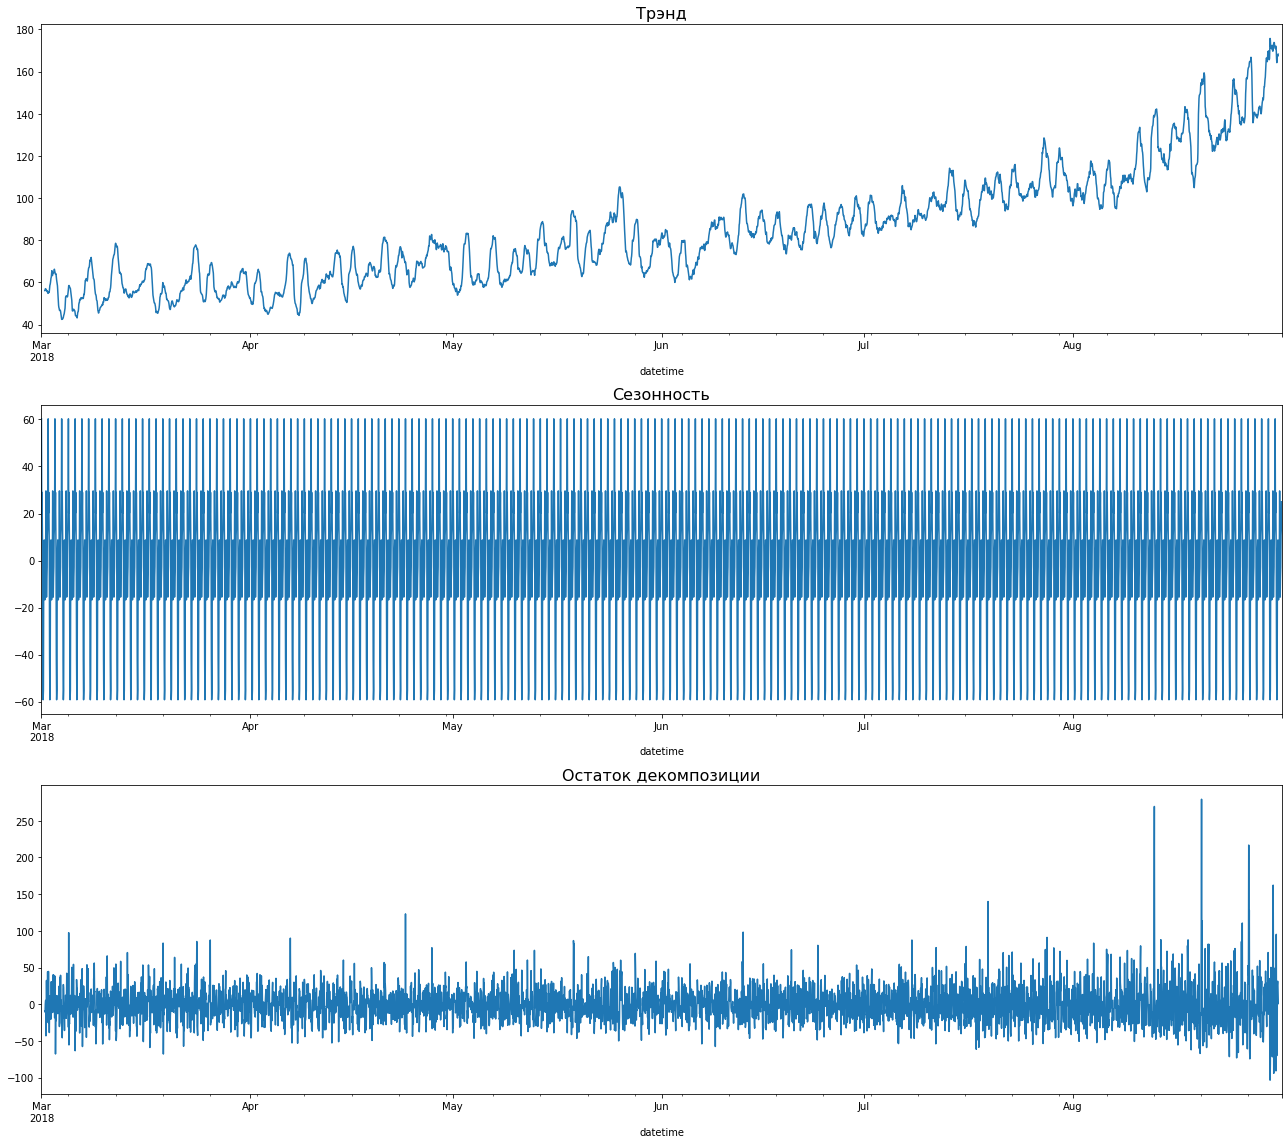

In [8]:
# оценим графики и выделим по ним фичи
plt.figure(figsize=(18, 16))

plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Трэнд', fontsize=16)

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность', fontsize=16)

#plt.subplot(313)
#decomposed.seasonal.tail(24*7).plot(x=plt.gca())
#plt.title('Сезонность 27/7', fontsize=16)

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток декомпозиции', fontsize=16)

plt.tight_layout()

Text(0.5, 1.0, 'Сезонность 24*7 / час*дней')

<Figure size 1296x1152 with 0 Axes>

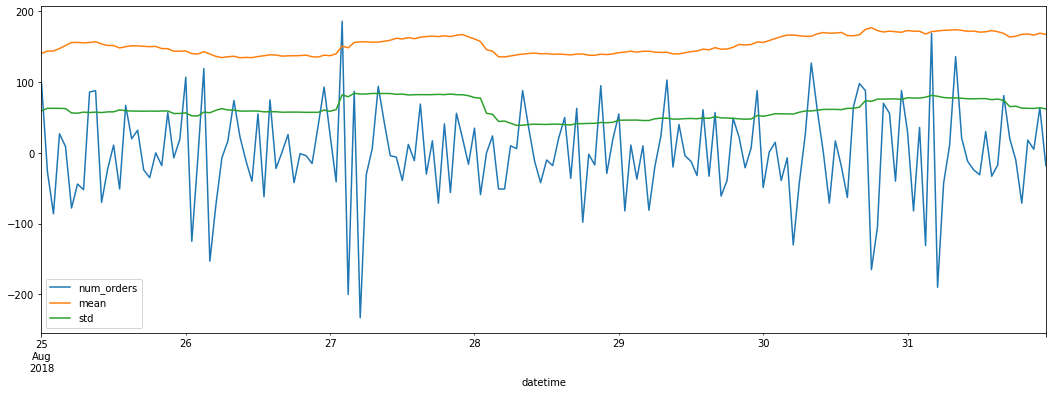

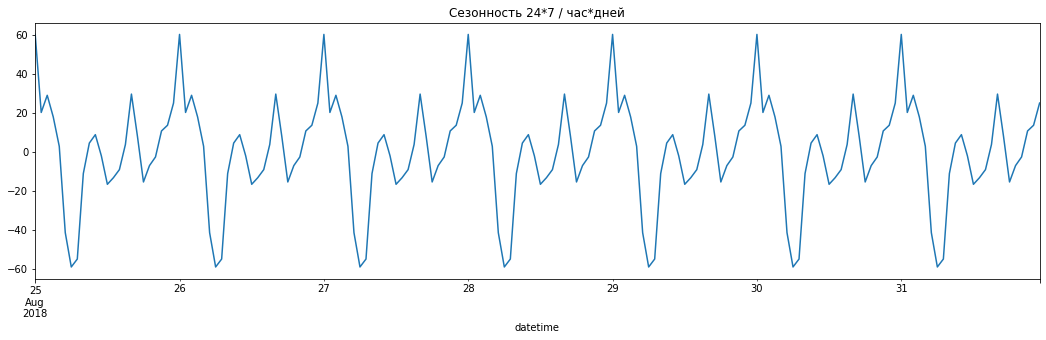

In [9]:
# оценим поближе разность временного ряда
df_shift = df - df.shift()
df_shift['mean'] = df['num_orders'].rolling(24).mean()
df_shift['std'] = df['num_orders'].rolling(24).std()

plt.figure(figsize=(18, 16))
df_shift.tail(24*7).plot(figsize=(18, 6))

# оценим графики сезонности поближе, выделим фичи
plt.figure(figsize=(18, 16))
plt.subplot(313)
decomposed.seasonal.tail(24*7).plot(x=plt.gca())
plt.title('Сезонность 24*7 / час*дней')

In [10]:
# функция добавления признаков по временному ряду

def make_features(data, max_lag, rolling_mean_size):
   
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [11]:
# добавим выбранные признаки
make_features(df, 4, 24)
df.head(30)

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN
2018-03-01 05:00:00,6,5,3,43.0,66.0,71.0,85.0,NaN
2018-03-01 06:00:00,12,6,3,6.0,43.0,66.0,71.0,NaN
2018-03-01 07:00:00,15,7,3,12.0,6.0,43.0,66.0,NaN
2018-03-01 08:00:00,34,8,3,15.0,12.0,6.0,43.0,NaN


In [12]:
# разделим на выборки в соотношении 90% : 10% / train : test
train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state=12345)
train = train.dropna()

In [13]:
# делим выборки на фичи и целевой признак

features_train = train.drop(['num_orders'],axis = 1) 
target_train = train['num_orders'] 
 
features_test = test.drop(['num_orders'],axis = 1) 
target_test = test['num_orders'] 

display(features_train.shape)
display(features_test.shape)

(3950, 7)

(442, 7)

## Обучение моделей

In [14]:
# определим 'randome_state'
STATE = 12345
# создадим список для словарей с результатами
scores = []

### Функции

In [15]:
# Функция печати результата работы модели
def print_result(result, params=0):
    '''
    Функция выводит на печать результаты работы модели
       - result - словарь(имя модели, время обучения, Время предсказания, RMSE)
       - params - гиперпараметры модели
    '''
    print('-' * 100)
    print(f'Для модели {result["model"]}')
    print(f'Гиперпараметры: {params}')
    print(f'RMSE = {result["rmse"]:.0f}')
    print(f'Время обучения: {result["learning_time"]:0.1f} секунд')
    print('-' * 100)

In [16]:
# Функция объединения результатов обучения разных моделей
def union_results(scores):
    '''
    Функция для объединения результатов обучения разных моделей
    scores - список словарей results с результатами обучения на выходе функций с моделями
    '''
    # словарь с готовыми ключами и пустыми списками в нем
    results = {i: [] for i in scores[0].keys()}

    # собираем все результаты в словарь 'results'
    for result in scores:
        for key, value in result.items():
            results[key].append(value)

        # собираем результаты в таблицу
    results = pd.DataFrame(results)
    return results

In [17]:
# функция подбора гиперпараметров OPTUNA
def optuna_hyper(name, objective):
    '''
    На вход:
        name - название модели, например name=RandomForestRegressor
        objective - имя функции нужных входных параметров, например objective=objective_dtr
    '''
    # t0 - время начало отсчета
    t0 = time.perf_counter()

    num_trials = 10  # можно стандартные 10 выставить

    study = optuna.create_study(study_name=name, direction='maximize')
    study.optimize(objective, n_trials=num_trials)  # , timeout=400)

    # Печать лучших параметров и метрики
    print(f'best params: {study.best_params}')
    print('RMSE = {:.0f}'.format(-study.best_value))

    # Печать времени подбора параметров
    print(f'elapsed time: {time.perf_counter() - t0:0.1f}s')

    return study.best_params

### Линейная регрессия

In [18]:
# функция LinearRegression

def model_linear_regression(features_train, features_test, target_train, target_test):
    t0 = time.perf_counter()
    model = LinearRegression().fit(features_train, target_train)
    t1 = time.perf_counter()
    prediction = model.predict(features_test)
    rmse = mean_squared_error(target_test, prediction, squared=False)

    # Сбор результатов в словарь
    result = {'model': 'LinearRegression',
              'learning_time': t1-t0, 'rmse': rmse}
    # Печать результатов
    print_result(result)
    return result, prediction

### Дерево решений

In [19]:
# функция DecisionTreeRegressor

def model_decision_tree(features_train, features_test, target_train, target_test, params):
    """
    На выходе функция выдает RMSE модели и предсказания.
    """
    t0 = time.perf_counter()
    model = DecisionTreeRegressor(**params, random_state=STATE)
    model.fit(features_train, target_train)
    t1 = time.perf_counter()
    prediction = model.predict(features_test)
    rmse = mean_squared_error(target_test, prediction, squared=False)

    # Сбор результатов в словарь
    result = {'model': 'DecisionTreeRegressor',
              'learning_time': t1-t0, 'rmse': rmse}
    # Печать результатов
    print_result(result, params)
    return result, prediction

In [20]:
# функция DecisionTreeRegressor objective для OPTUNA

def objective_dtr(trial):
    '''
    DecisionTreeRegressor objective for OPTUNA
    '''
    param = {
        'max_depth': trial.suggest_int("max_depth", 1, 40),
        'min_samples_split': trial.suggest_int("min_samples_split", 2, 50),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 2, 50),
        # 'max_features': trial.suggest_categorical("max_features", ["auto", "sqrt"]),
        'random_state': STATE
    }

    clf = DecisionTreeRegressor(**param)
    tscv = TimeSeriesSplit(n_splits=3)  # Кросс-валидатор для временных рядов

    return cross_val_score(clf, features_train, target_train, n_jobs=-1, cv=tscv,
                           scoring='neg_root_mean_squared_error').mean()

In [21]:
%%time
# подбираем гиперпараметры DecisionTreeRegressor через OPTUNA

opt_dtr = optuna_hyper(DecisionTreeRegressor, objective_dtr)
display(opt_dtr)

[I 2022-06-14 11:30:32,360] A new study created in memory with name: <class 'sklearn.tree._classes.DecisionTreeRegressor'>
[I 2022-06-14 11:30:32,389] Trial 0 finished with value: -30.721767433852335 and parameters: {'max_depth': 26, 'min_samples_split': 47, 'min_samples_leaf': 30}. Best is trial 0 with value: -30.721767433852335.
[I 2022-06-14 11:30:32,416] Trial 1 finished with value: -30.738573677638914 and parameters: {'max_depth': 37, 'min_samples_split': 13, 'min_samples_leaf': 32}. Best is trial 0 with value: -30.721767433852335.
[I 2022-06-14 11:30:32,437] Trial 2 finished with value: -34.60266711336106 and parameters: {'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 19}. Best is trial 0 with value: -30.721767433852335.
[I 2022-06-14 11:30:32,453] Trial 3 finished with value: -38.02039196363996 and parameters: {'max_depth': 1, 'min_samples_split': 48, 'min_samples_leaf': 23}. Best is trial 0 with value: -30.721767433852335.
[I 2022-06-14 11:30:32,492] Trial 4 finis

best params: {'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 11}
RMSE = 30
elapsed time: 0.3s


{'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 11}

CPU times: user 254 ms, sys: 10.6 ms, total: 264 ms
Wall time: 271 ms


### Случайный лес 

In [22]:
# функция RandomForestRegressor

def model_random_forest(features_train, features_test, target_train, target_test, params):
    t0 = time.perf_counter()
    model = RandomForestRegressor(**params, random_state=STATE)
    model.fit(features_train, target_train)
    t1 = time.perf_counter()
    prediction = model.predict(features_test)
    rmse = mean_squared_error(target_test, prediction, squared=False)

    # Сбор результатов в словарь
    result = {'model': 'RandomForestRegressor',
              'learning_time': t1-t0, 'rmse': rmse}
    # Печать результатов
    print_result(result, params)
    return result, prediction

In [23]:
# функция RandomForestRegressor objective для OPTUNA

def objective_rfr(trial):
    param = {
        'n_estimators': trial.suggest_int("n_estimators", 30, 70),
        'max_depth': trial.suggest_int("max_depth", 20, 55),
        'min_samples_split': trial.suggest_int("min_samples_split", 2, 50),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 2, 50),
#        'max_features': trial.suggest_categorical("max_features", ["auto", "sqrt"]),
#        'bootstrap': True,
        'random_state': STATE
    }

    clf = RandomForestRegressor(**param)
    tscv = TimeSeriesSplit(n_splits=3)  # Кросс-валидатор для временных рядов

    return cross_val_score(clf, features_train, target_train, n_jobs=-1, cv=tscv,
                           scoring='neg_root_mean_squared_error').mean()

In [24]:
%%time
# подбираем гиперпараметры RandomForestRegressor через OPTUNA

opt_rfr = optuna_hyper(RandomForestRegressor, objective_rfr)
display(opt_rfr)

[I 2022-06-14 11:30:32,684] A new study created in memory with name: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
[I 2022-06-14 11:30:33,076] Trial 0 finished with value: -31.339762625065372 and parameters: {'n_estimators': 38, 'max_depth': 48, 'min_samples_split': 19, 'min_samples_leaf': 44}. Best is trial 0 with value: -31.339762625065372.
[I 2022-06-14 11:30:33,702] Trial 1 finished with value: -28.215635511065432 and parameters: {'n_estimators': 48, 'max_depth': 32, 'min_samples_split': 21, 'min_samples_leaf': 7}. Best is trial 1 with value: -28.215635511065432.
[I 2022-06-14 11:30:34,406] Trial 2 finished with value: -29.089343937740583 and parameters: {'n_estimators': 64, 'max_depth': 54, 'min_samples_split': 50, 'min_samples_leaf': 5}. Best is trial 1 with value: -28.215635511065432.
[I 2022-06-14 11:30:35,048] Trial 3 finished with value: -29.51445562822269 and parameters: {'n_estimators': 55, 'max_depth': 23, 'min_samples_split': 30, 'min_samples_leaf': 22}. Best i

best params: {'n_estimators': 56, 'max_depth': 33, 'min_samples_split': 6, 'min_samples_leaf': 8}
RMSE = 28
elapsed time: 5.9s


{'n_estimators': 56,
 'max_depth': 33,
 'min_samples_split': 6,
 'min_samples_leaf': 8}

CPU times: user 5.87 s, sys: 39.7 ms, total: 5.91 s
Wall time: 5.93 s


### Модель LGBMRegressor

In [25]:
# функция LGBMRegressor
def model_lgbm_regressor(features_train, features_test, target_train, target_test, params):
    """
    На выходе функция выдает RMSE модели и предсказания.
    """
    t0 = time.perf_counter()
    model = LGBMRegressor(**params, random_state=STATE)
    model.fit(features_train, target_train)
    t1 = time.perf_counter()
    prediction = model.predict(features_test)
    rmse = mean_squared_error(target_test, prediction, squared=False)

    # Сбор результатов в словарь
    result = {'model': 'LGBMRegressor', 'learning_time': t1-t0, 'rmse': rmse}
    # Печать результатов
    print_result(result, params)

    return result, prediction

In [26]:
# функция LGBMRegressor objective for OPTUNA
def objective_lgbmr(trial):
    '''
    LGBMRegressor objective for OPTUNA
    '''
    param = {
        'n_estimators': trial.suggest_int("n_estimators", 5, 300),
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 1.0),
        'max_depth': trial.suggest_int("max_depth", 1, 21),
        'random_state': STATE
    }

    clf = LGBMRegressor(**param)
    tscv = TimeSeriesSplit(n_splits=3)  # Кросс-валидатор для временных рядов

    return cross_val_score(clf, features_train, target_train, n_jobs=-1, cv=tscv,
                           scoring='neg_root_mean_squared_error').mean()

In [ ]:
%%time
# подбираем гиперпараметры LGBMRegressor через OPTUNA

opt_lgbmr = optuna_hyper(LGBMRegressor, objective_lgbmr)

[I 2022-06-14 11:30:38,641] A new study created in memory with name: <class 'lightgbm.sklearn.LGBMRegressor'>


### Модель CatBoostRegressor

In [ ]:
# функция подбора гиперпараметров OPTUNA для CatBoostRegressor
def optuna_hyper(name, objective):
    '''
    На вход:
        name - название модели, например name=RandomForestRegressor
        objective - имя функции нужных входных параметров, например objective=objective_dtr
    '''
    # t0 - время начало отсчета
    t0 = time.perf_counter()

    num_trials = 5  # изменяем, так как по скорости CatBoostRegressor после 5-6 очень долго прогоняет тесты

    study = optuna.create_study(study_name=name, direction='maximize')
    study.optimize(objective, n_trials=num_trials)  # , timeout=400)

    # Печать лучших параметров и метрики
    print(f'best params: {study.best_params}')
    print('RMSE = {:.0f}'.format(-study.best_value))

    # Печать времени подбора параметров
    print(f'elapsed time: {time.perf_counter() - t0:0.1f}s')

    return study.best_params

In [ ]:
# функция CatBoostRegressor
def model_catboost_regressor(features_train, features_test,
                             target_train, target_test, params, cat_features=None):
    """
    На выходе функция выдает RMSE модели и предсказания.
    """
    t0 = time.perf_counter()
    model = CatBoostRegressor(
        **params, cat_features=cat_features, loss_function='RMSE', random_state=STATE)
    model.fit(features_train, target_train)#, verbose=10)
    t1 = time.perf_counter()
    prediction = model.predict(features_test)
    rmse = mean_squared_error(target_test, prediction, squared=False)

    # Сбор результатов в словарь
    result = {'model': 'CatBoostRegressor',
              'learning_time': t1-t0, 'rmse': rmse}
    # Печать результатов
    print_result(result, params)

    return result, prediction

In [ ]:
# функция CatBoostRegressor objective для OPTUNA
def objective_cbr(trial):
    '''
    CatBoostRegressor objective for OPTUNA
    '''
    param = {
        'iterations': trial.suggest_int("iterations", 10, 150),
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.06),
        'depth': trial.suggest_int("depth", 1, 16),
#        'l2_leaf_reg': trial.suggest_int("l2_leaf_reg", 2, 30),
#        'eval_metric': "RMSE",
#        'cat_features': cat_features
    }

    clf = CatBoostRegressor(**param)
    tscv = TimeSeriesSplit(n_splits=3)  # Кросс-валидатор для временных рядов

    return cross_val_score(clf, features_train, target_train, n_jobs=-1, cv=tscv,
                           scoring='neg_root_mean_squared_error').mean()

In [ ]:
%%time
# подбираем гиперпараметры CatBoostRegressor через OPTUNA

opt_cbr = optuna_hyper(CatBoostRegressor, objective_cbr)

###  Вывод:
Выбрано и обучено пять моделей: LinearRegression, DecisionTreeRegressor, RandomForestRegressor, LGBMRegressor, CatBoostRegressor. 

## Тестирование
Прогоняем данные по всем моделям. Смотрим на результаты RMSE на тестовой выборке. 

In [ ]:
%%time
# вызов функции LinearRegression
scores_LR = model_linear_regression(
    features_train, features_test, target_train, target_test)
# добавление словаря в список "scores"
scores.append(scores_LR[0])
display(scores_LR[0])
plt.figure(figsize=(16, 8))
plt.scatter(y=target_test, x=target_test.index)
plt.scatter(y=scores_LR[1], x=target_test.index)

In [ ]:
plt.figure(figsize=(16, 8))
plt.xlim(pd.Timestamp('2018-08-15'), pd.Timestamp('2018-08-18'))
plt.title('Результаты модели, 2 дня', fontsize=16)
plt.xlabel('Дата, время', fontsize=16)
plt.ylabel('Число заказов', fontsize=16)
plt.plot(target_test.index, target_test)
plt.plot(target_test.index, scores_LR[1])
plt.legend(['реальные', 'предсказанные'], loc='upper right', fontsize=12)

In [ ]:
%%time
# вызов функции DecisionTreeRegressor

scores_DTR = model_decision_tree(features_train, features_test, target_train,
                                 target_test, params=opt_dtr)
# добавление словаря в список "scores"
scores.append(scores_DTR[0])
display(scores_DTR[0])
plt.figure(figsize=(16, 8))
plt.scatter(y=target_test, x=target_test.index)
plt.scatter(y=scores_DTR[1], x=target_test.index)

In [ ]:
plt.figure(figsize=(16, 8))
plt.xlim(pd.Timestamp('2018-08-15'), pd.Timestamp('2018-08-18'))
plt.title('Результаты модели, 2 дня', fontsize=16)
plt.xlabel('Дата, время', fontsize=16)
plt.ylabel('Число заказов', fontsize=16)
plt.plot(target_test.index, target_test)
plt.plot(target_test.index, scores_DTR[1])
plt.legend(['реальные', 'предсказанные'], loc='upper right', fontsize=12)

In [ ]:
%%time
# вызов функции RandomForestRegressor()
scores_RFR = model_random_forest(features_train, features_test,
                                 target_train, target_test, params=opt_rfr)
# добавление словаря в список "scores"
scores.append(scores_RFR[0])
display(scores_RFR[0])
plt.figure(figsize=(16, 8))
plt.scatter(y=target_test, x=target_test.index)
plt.scatter(y=scores_RFR[1], x=target_test.index)

In [ ]:
plt.figure(figsize=(16, 8))
plt.xlim(pd.Timestamp('2018-08-15'), pd.Timestamp('2018-08-18'))
plt.title('Результаты модели, 2 дня', fontsize=16)
plt.xlabel('Дата, время', fontsize=16)
plt.ylabel('Число заказов', fontsize=16)
plt.plot(target_test.index, target_test)
plt.plot(target_test.index, scores_RFR[1])
plt.legend(['реальные', 'предсказанные'], loc='upper right', fontsize=12)

In [ ]:
%%time
# вызов функции LGBMRegressor()
scores_LGBM = model_lgbm_regressor(features_train, features_test,
                                   target_train, target_test, params=opt_lgbmr)
# добавление словаря в список "scores"
scores.append(scores_LGBM[0])
scores_LGBM[0]
plt.figure(figsize=(16, 8))
plt.scatter(y=target_test, x=target_test.index)
plt.scatter(y=scores_LGBM[1], x=target_test.index)

In [ ]:
plt.figure(figsize=(16, 8))
plt.xlim(pd.Timestamp('2018-08-15'), pd.Timestamp('2018-08-18'))
plt.title('Результаты модели, 2 дня', fontsize=16)
plt.xlabel('Дата, время', fontsize=16)
plt.ylabel('Число заказов', fontsize=16)
plt.plot(target_test.index, target_test)
plt.plot(target_test.index, scores_LGBM[1])
plt.legend(['реальные', 'предсказанные'], loc='upper right', fontsize=12)

In [ ]:
%%time
# вызов функции CatBoostRegressor

scores_cbr = model_catboost_regressor(
    features_train, features_test, target_train, target_test,
    params=opt_cbr, cat_features=None)
# добавление словаря в список "scores"
scores.append(scores_cbr[0])
display(scores_cbr[0])

In [ ]:
plt.figure(figsize=(16, 8))
plt.scatter(y=target_test, x=target_test.index)
plt.scatter(y=scores_cbr[1], x=target_test.index)

In [ ]:
plt.figure(figsize=(16, 8))
plt.xlim(pd.Timestamp('2018-08-15'), pd.Timestamp('2018-08-18'))
plt.title('Результаты модели, 2 дня', fontsize=16)
plt.xlabel('Дата, время', fontsize=16)
plt.ylabel('Число заказов', fontsize=16)
plt.plot(target_test.index, target_test)
plt.plot(target_test.index, scores_cbr[1])
plt.legend(['реальные', 'предсказанные'], loc='upper right', fontsize=12)

### Сравнение

In [ ]:
union_results(scores)

###  Вывод:
По скорости обучения и по минимальному значению RMSE выбор остается в пользу модели LGBMRegressor. При этом все рассмотренные модели показывают небольшое значение отклонения предсказаний от истиных значений. RMSE между 7.5 и 8.5.